Correct the log distance ratios for the size-limited selection of the SGA.  This follows the method outlined in [Springob et al. (2015)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.456.1886S/abstract).

In [10]:
import numpy as np

from scipy.special import gammaln
from scipy.optimize import minimize

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy import units as u

import matplotlib.pyplot as plt

# Import data

## Y1 data

In [2]:
filename = 'SGA_iron_jointTFR-varyV0-perpdwarf-fitH0_zCMB0p1_moduli.fits'

hdul = fits.open(filename)
SGA_TF = Table(hdul[1].data)
hdr = hdul[0].header
hdul.close()

H0 = hdr['H0']

SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,Z_DESI_CMB,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,R_ABSMAG_SB26_TF_ERR_SYS,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005

## SGA catalog

In [3]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

# 1. Compute the size function of the target sample

We're starting by defining the target sample as the full SGA.  This is technically not correct (the TF sample is a subset of the full SGA), but it's easier to start with this.

## Compute the physical size of the SGA galaxies

**Note:** We will need to use `Z_LEDA` because not all the SGA galaxies have been observed by DESI

In [4]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

In [5]:
# Mask redshift values of -99 (= missing)
SGA['Z_LEDA'][SGA['Z_LEDA'] == -99] = np.nan

dist = Distance(z=np.abs(SGA['Z_LEDA']), cosmology=Planck18_h)

SGA['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*SGA['D26']*u.arcmin)

SGA['DIST_MAX'] = 0.5*SGA['D26_kpc']/np.tan(0.1*u.arcmin)

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2387: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*inputs)


## Plot the size function

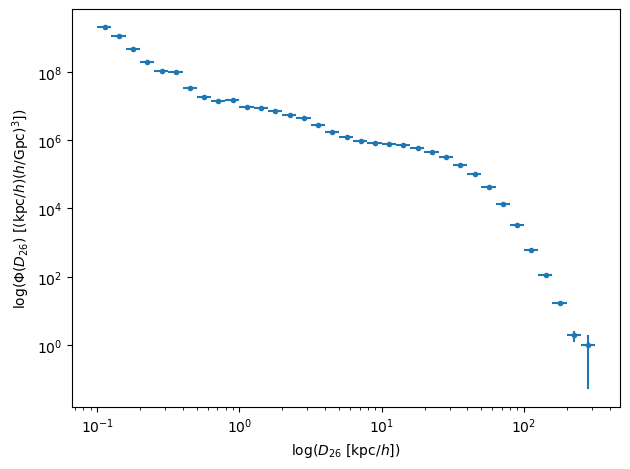

In [107]:
# D26kpc_binwidth = 5
# D26kpc_bins = np.arange(0, 200, D26kpc_binwidth)
D26kpc_bins = np.logspace(-1, 2.5, 36)
D26kpc_binwidth = D26kpc_bins[1:] - D26kpc_bins[:-1]

# ignore NaN values
good = np.isfinite(SGA['DIST_MAX']) & (SGA['DIST_MAX'] > 0)

size_func, bin_edges = np.histogram(SGA['D26_kpc'][good], 
                                    bins=D26kpc_bins, 
                                    weights=1/SGA['DIST_MAX'][good].to('Gpc').value**3, 
                                    # density=True
                                   )
N, bin_edges = np.histogram(SGA['D26_kpc'][good], 
                            bins=D26kpc_bins)

plt.figure(tight_layout=True)

plt.errorbar(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
             size_func, 
             xerr=0.5*D26kpc_binwidth, 
             # yerr=1/np.sqrt(N), 
             yerr=1/np.sqrt(size_func),
             fmt='.')

plt.xscale('log')
plt.yscale('log')

# plt.xlabel('$D_{26}$ [kpc/$h$]')
plt.xlabel('log($D_{26}$ [kpc/$h$])')
plt.ylabel(r'log($\Phi(D_{26})$ [(kpc/$h$)($h$/Gpc)$^3$])');

## Parameterize the size function

We'll try a Schechter function first:
\begin{equation}
  dn(R_{26}) = \phi(R_{26}) dR_{26} = \ln 10 \phi^* \left( \frac{R_{26}}{R_{26}^*} \right)^{\alpha + 1} e^{-R_{26}/R_{26}^*} \, d\log R_{26}
\end{equation}

In [68]:
def Schecht_log(x, p, a, xs):
    '''
    Compute the Schechter function for quantity x, which is assumed to be in log-space.


    PARAMETERS
    ==========
    x : ndarray of length (N,)
        x-parameter of who's counts are being modeled by the Schechter function.  
        Assumed to be in log-space.
    p : float
        phi^*, the normalization of the Schechter function
    a : float
        alpha, the slope of the faint-end
    xs : float
        "knee" of the Schechter function
    '''
    return np.log(10) * p * (x/xs)**(a + 1) * np.exp(-x/xs)


def Schecht(x, p, a, xs):
    '''
    Compute the Schechter function for quantity x, which is assumed to be in linear space.


    PARAMETERS
    ==========
    x : ndarray of length (N,)
        x-parameter of who's counts are being modeled by the Schechter function.
    p : float
        phi^*, the normalization of the Schechter function
    a : float
        alpha, the slope of the faint-end
    xs : float
        "knee" of the Schechter function
    '''
    return p * (x/xs)**a * np.exp(-x/xs) / xs


def logL(params, n, x):
    '''
    Log-likelihood

    PARAMETERS
    ==========
    params : list or ndarray
        List of 2xthree parameters: scale factor, slope, and knee
    n : ndarray
        (weighted) binned counts
    x : ndarray
        Bin centers used to construct the histogrammed counts n

    RETURNS
    =======
    logL : float
        Log likelihood of set n given model parameters
    '''

    # p, a, xs = params

    lambda1 = Schecht_log(x, *params[:3]) + Schecht_log(x, *params[3:])

    lambda1[lambda1 <= 0] = np.finfo(dtype=np.float64).tiny

    return np.sum(n*np.log(lambda1) - lambda1 - gammaln(n + 1))


def nlogL(params, n, x):
    '''Negative log likelihood, for minimizers'''
    return -logL(params, n, x)

In [108]:
bounds1 = [[3, 8], [-3, 0], [10, 20]]
bounds2 = [[5, 10], [-1, 0], [0, 5]]

p0 = [10**(np.random.uniform(bounds1[0][0], bounds1[0][1])), 
      np.random.uniform(bounds1[1][0], bounds1[1][1]), 
      np.random.uniform(bounds1[2][0], bounds1[2][1]), 
      10**(np.random.uniform(bounds2[0][0], bounds2[0][1])), 
      np.random.uniform(bounds2[1][0], bounds2[1][1]), 
      np.random.uniform(bounds2[2][0], bounds2[2][1])]

result = minimize(nlogL, p0, args=(size_func, bin_edges[:-1] + 0.5*D26kpc_binwidth), bounds=[*bounds1, *bounds2])

result

/tmp/ipykernel_1835044/1353962020.py:18: RuntimeWarning: divide by zero encountered in true_divide
  return np.log(10) * p * (x/xs)**(a + 1) * np.exp(-x/xs)
/tmp/ipykernel_1835044/1353962020.py:18: RuntimeWarning: invalid value encountered in multiply
  return np.log(10) * p * (x/xs)**(a + 1) * np.exp(-x/xs)


      fun: 34168607113.25825
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.41738893e+08,  8.53653565e+09,  1.18861379e+08, -2.16026288e+08,
        7.31986694e+09,  4.67765811e+08])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 14
      nit: 0
     njev: 2
   status: 2
  success: False
        x: array([ 8.00000000e+00, -2.49031682e-01,  1.19500550e+01,  1.00000000e+01,
       -3.71477315e-03,  4.40570049e+00])

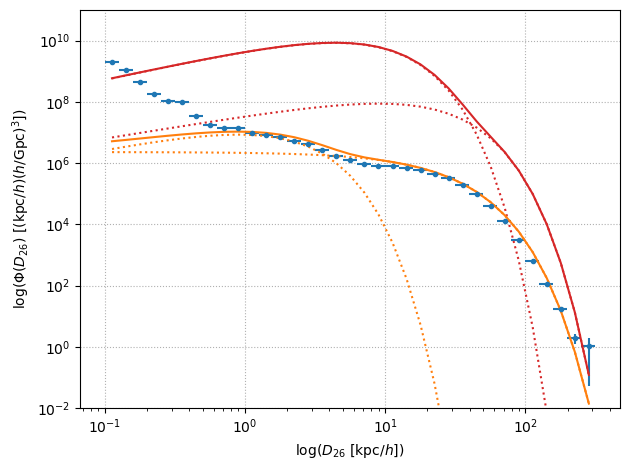

In [111]:
plt.figure(tight_layout=True)

plt.errorbar(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
             size_func, 
             xerr=0.5*D26kpc_binwidth, 
             # yerr=1/np.sqrt(N), 
             yerr=1/np.sqrt(size_func),
             fmt='.')

# Actual fit
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 10**result.x[0], result.x[1], result.x[2]) + Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 10**result.x[3], result.x[4], result.x[5]),
         c='tab:red'
        )
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 10**result.x[0], result.x[1], result.x[2]),
         ':', c='tab:red'
        )
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 10**result.x[3], result.x[4], result.x[5]),
         ':', c='tab:red'
        )

# Manual fit
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 10**6, -1, 15) + Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 10**7, -0.1, 1)
        )
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 10**6, -1, 15), # phi_* = 10**6
         ':', c='tab:orange'
        )
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 10**7, -0.1, 1), # phi_* = 10**7
         ':', c='tab:orange'
        )

plt.xscale('log')
plt.yscale('log')

plt.ylim([10**-2, 10**11])

plt.grid(ls=':')

# plt.xlabel('$D_{26}$ [kpc/$h$]')
plt.xlabel('log($D_{26}$ [kpc/$h$])')
plt.ylabel(r'log($\Phi(D_{26})$ [(kpc/$h$)($h$/Gpc)$^3$])');